
# t-SNE with all jets

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import sys
sys.path.append(os.path.realpath(".."))
import tools
import EnergyFlow.ef_tools as ef_tools
import numpy as np

with open("../filepath.txt", 'r') as f:
    filename = f.read().strip("\n")   

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file(filename, njets=10)
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)

Using TensorFlow backend.


padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
307055 events after ensuring we only have 3 tags
303931 events after ensuring there is at most 1 untagged jet


Loading model... 
Using architecture: ../models/architecture_06_07_2020.json 
and weights: ../models/weights_06_07_2020.h5
303931


100%|██████████| 303931/303931 [00:02<00:00, 120222.06it/s]


overall accuracy: 88.27 percent
ignoring 0.00 percent (0 events) of 303931 events


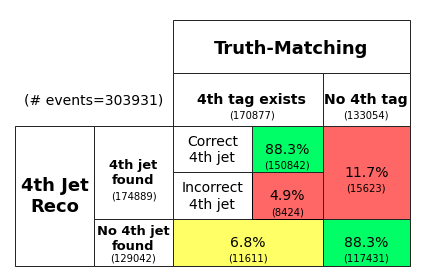

In [2]:
import importlib
import ptetaphi_nn
import awkward
import uproot_methods as urm

importlib.reload(ptetaphi_nn)

events = awkward.Table()
# add data to table
events['resolved_lv'] = urm.TLorentzVectorArray.from_ptetaphie(X[:,:,0], X[:,:,1], X[:,:,2],X[:,:,3])
truths = y[:,:-1].copy().astype(int)
truths[:,:3] = 1 
events['truth'] = truths  # no no-jet jet
tags = X[:,:,4]
events['tag'] = tags

nn = ptetaphi_nn.PtEtaPhiNN(events, load=("../models/architecture_06_07_2020.json", "../models/weights_06_07_2020.h5"), njets=X.shape[1], chop=0)

print(len(events))

selections = nn.evaluate(events)

In [3]:
n=5000

import numpy as np
from sklearn.datasets import load_digits
from scipy.spatial.distance import pdist
from sklearn.manifold.t_sne import _joint_probabilities
from scipy import linalg
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

tsne = TSNE(perplexity=10, verbose=True, learning_rate=1, n_iter=100000)
# :n so this doesn't take eons
x_2d = np.array([x.flatten() for x in X])[:n, :]


pt = X[:n,:,0]
njets = np.count_nonzero(pt, axis=1)


/home/cmccracken/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


In [4]:
from tqdm import tqdm
# get the category of each event:
"""
TABLE WITH CATEGORIES
              _______________
______________| TRUTH       |
| RECO        | Yep  | Nope |
| Yep, good   | 0    | 3    |
| Yep, bad    | 1    |      |
| Nope        | 2    | 4    |
-----------------------------
0 - 4th exists, was correctly selected
1 - 4th exists, incorrect jet selected
2 - 4th exists, no jet selected
3 - 4th does not exist, jet selected incorrectly
4 - 4th does not exist, no jet selected (correctly)
5 - None of the above

"""
# total number of events
n_events = len(truths)

# truths, tags selections are arrays from above,
# categories[i] = 0,1,2,3,4,5 for each event
categories = np.zeros(n_events, dtype=int)

# this loop is almost identical to the one in tools.evaluate_model
for i in tqdm(range(n_events)):
    selection = selections[i]
    truth = truths[i]
    tag = tags[i]

    selection_index = np.where(selection == 1)[0]
    n_selections = len(selection_index)
        
    if n_selections > 1:
        raise ValueError("why are you selecting more than 1?")

    untagged = np.logical_xor(truth, tag).astype(int)

    n_untagged = np.count_nonzero(untagged)

    if n_untagged == 0:  # should not have made any selection
        if n_selections != 0:  # made a selection, should not have
            categories[i] = 3
        else:  # good call, no selection
            categories[i] = 4
    elif n_untagged == 1:  # if we should have made 1 selection
        if n_selections == 0:  # no selection, bad
            categories[i] = 2
        elif n_selections == 1:  # 1 selection, good
            # was it the right jet though?
            right_selection = bool(truth[selection_index] == 1)
            if right_selection:
                categories[i] = 0
            else:
                categories[i] = 1
        else:
            raise ValueError("Why did you select more than 1 jet?")
    else:  # there were 2 or more untagged jets
        categories[i] = 5

print("\r", categories)

X_embedded = tsne.fit_transform(x_2d)
print(X_embedded.shape)

100%|██████████| 303931/303931 [00:02<00:00, 121974.44it/s]


 [3 4 4 ... 0 0 0]
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.023s...
[t-SNE] Computed neighbors for 5000 samples in 0.696s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 49.188046
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.299088
[t-SNE] KL divergence after 100000 iterations: 1.594896
(5000, 2)


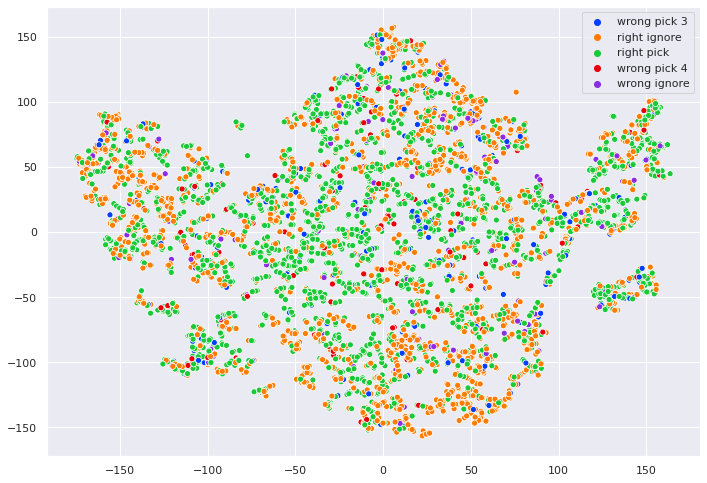

5000 5000


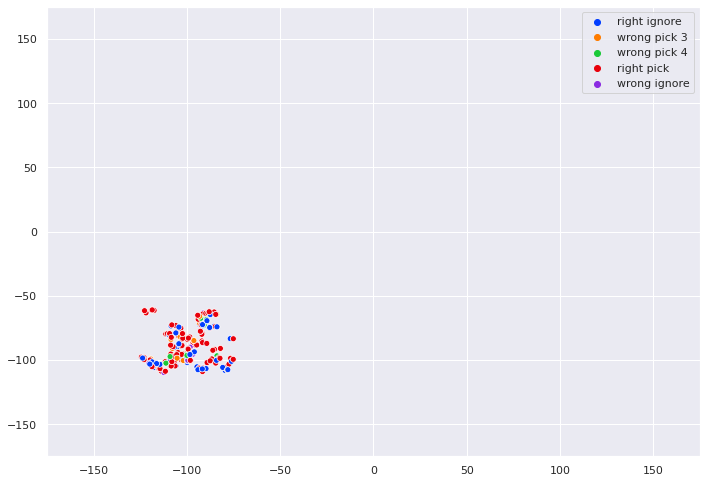

(-175.0, 175.0)

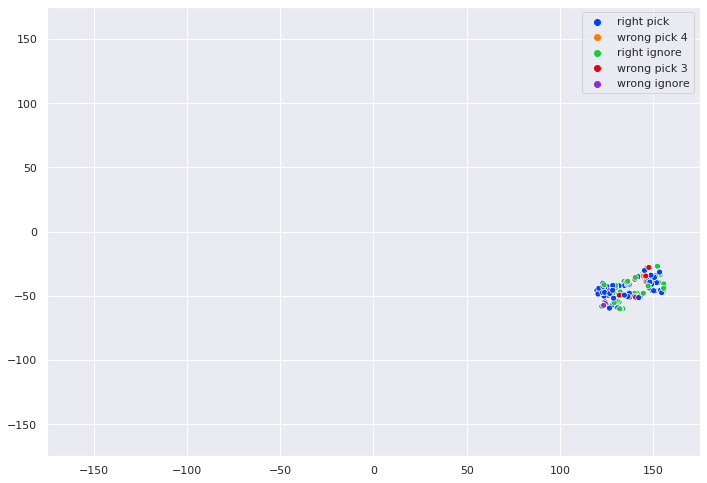

In [10]:
d = {
        0: "right pick",
        1: "wrong pick 4",
        2: "wrong ignore",
        3: "wrong pick 3",
        4: "right ignore",
    }
cat_words = np.array([d[c] for c in categories])

palette = sns.color_palette("bright", 5)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cat_words[:n], legend='full', palette=palette)
plt.show()
# filter for a bubble:

x = X_embedded[:,0]
y = X_embedded[:,1]

l_bubble = [True if (-125 < xi and xi < -75 and -110 < yi and yi < -60) else False for xi, yi, c in zip(x,y,cat_words)]
r_bubble = [True if (110 < xi and xi < 175 and -75 < yi and yi < -10) else False for xi, yi, c in zip(x,y,cat_words)]

print(len(l_bubble), len(r_bubble))
sns.scatterplot(x[l_bubble], y[l_bubble], hue=cat_words[:n][l_bubble], legend='full', palette=palette)
plt.xlim(-175, 175)
plt.ylim(-175, 175)
plt.show()

sns.scatterplot(x[r_bubble], y[r_bubble], hue=cat_words[:n][r_bubble], legend='full', palette=palette)
plt.xlim(-175, 175)
plt.ylim(-175, 175)


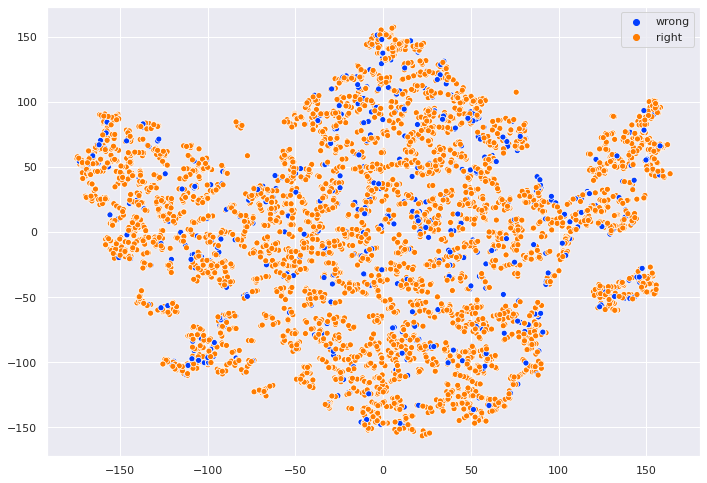

5000 5000


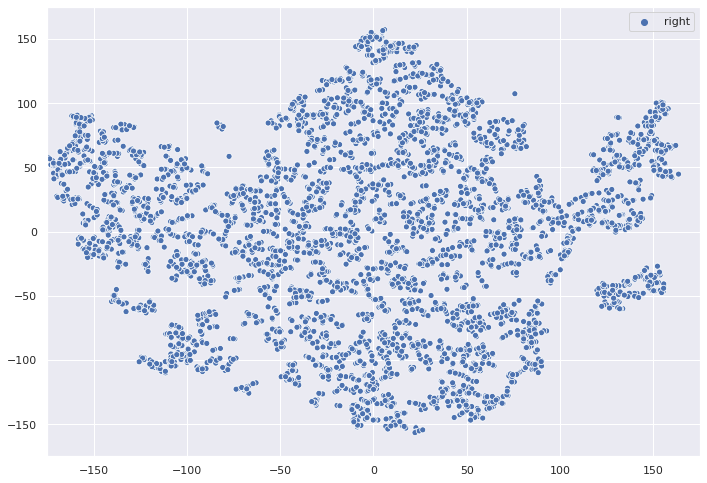

(-175.0, 175.0)

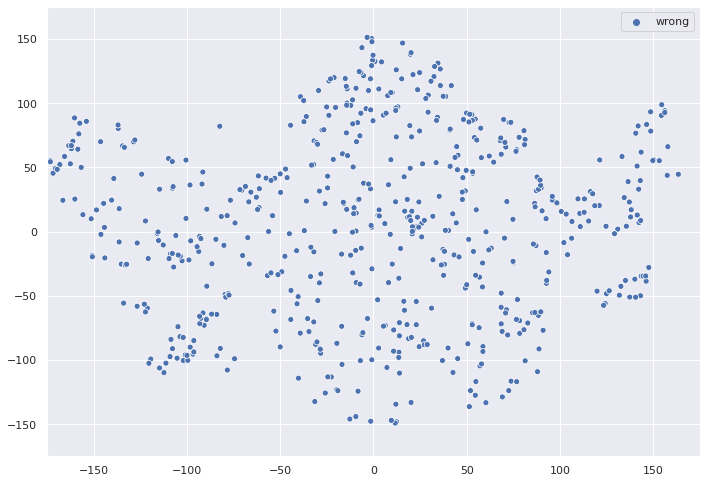

In [15]:
cat_words_2 = np.array(["right" if c in [0,4] else "wrong" for c in categories])

palette = sns.color_palette("bright", 2)

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=cat_words_2[:n], legend='full', palette=palette)
plt.show()
# filter for a bubble:

x = X_embedded[:,0]
y = X_embedded[:,1]

right_bubble = [True if (c == "right") else False for xi, yi, c in zip(x,y,cat_words_2)]
wrong_bubble = [True if (c == "wrong") else False for xi, yi, c in zip(x,y,cat_words_2)]

print(len(right_bubble), len(wrong_bubble))
sns.scatterplot(x[right_bubble], y[right_bubble], hue=cat_words_2[:n][right_bubble], legend='full')
plt.xlim(-175, 175)
plt.ylim(-175, 175)
plt.show()

sns.scatterplot(x[wrong_bubble], y[wrong_bubble], hue=cat_words_2[:n][wrong_bubble], legend='full')
plt.xlim(-175, 175)
plt.ylim(-175, 175)


In [16]:
pt_indices = [0,5,10,15,20,25,30,35,40,45]
eta_indices = [1,6,11,16,21,26,31,36,41,46]
phi_indices = [2,7,12,17,22,27,32,37,42,47]
E_indices = [3,8,13,18,23,28,33,38,43,48]
tag_indices = [4,9,14,19,24,29,34,39,44,49]

vectors = events.resolved_lv

pt_all = np.empty((n, 10))
eta_all = np.empty((n, 10))
phi_all = np.empty((n, 10))
E_all = np.empty((n, 10))
tag_all = np.empty((n, 10))

r_pt, r_eta, r_phi, r_E = [], [], [], []
l_pt, l_eta, l_phi, l_E = [], [], [], []
right_pt, right_eta, right_phi, right_E = [], [], [], []
wrong_pt, wrong_eta, wrong_phi, wrong_E = [], [], [], []

for i in range(n):
    pt_all[i] = x_2d[i][pt_indices]
    eta_all[i] = x_2d[i][eta_indices]
    phi_all[i] = x_2d[i][phi_indices]
    E_all[i] = x_2d[i][E_indices]

    if r_bubble[i]:
        r_pt.append(pt_all[i])
        r_eta.append(eta_all[i])
        r_phi.append(phi_all[i])
        r_E.append(E_all[i])
    if l_bubble[i]:
        l_pt.append(pt_all[i])
        l_eta.append(eta_all[i])
        l_phi.append(phi_all[i])
        l_E.append(E_all[i])

    if cat_words_2[i] == "right":
        right_pt.append(pt_all[i])
        right_eta.append(eta_all[i])
        right_phi.append(phi_all[i])
        right_E.append(E_all[i])
    if cat_words_2[i] == "wrong":
        wrong_pt.append(pt_all[i])
        wrong_eta.append(eta_all[i])
        wrong_phi.append(phi_all[i])
        wrong_E.append(E_all[i])



r_pt = np.array(r_pt)
r_eta = np.array(r_eta)
r_phi = np.array(r_phi)
r_E = np.array(r_E)
l_pt = np.array(l_pt)
l_eta = np.array(l_eta)
l_phi = np.array(l_phi)
l_E = np.array(l_E)
right_pt = np.array(right_pt)
right_eta = np.array(right_eta)
right_phi = np.array(right_phi)
right_E = np.array(right_E)
wrong_pt = np.array(wrong_pt)
wrong_eta = np.array(wrong_eta)
wrong_phi = np.array(wrong_phi)
wrong_E = np.array(wrong_E)



print(pt_all.shape)

print(r_pt.shape)



(5000, 10)
(125, 10)


28258
854
1438


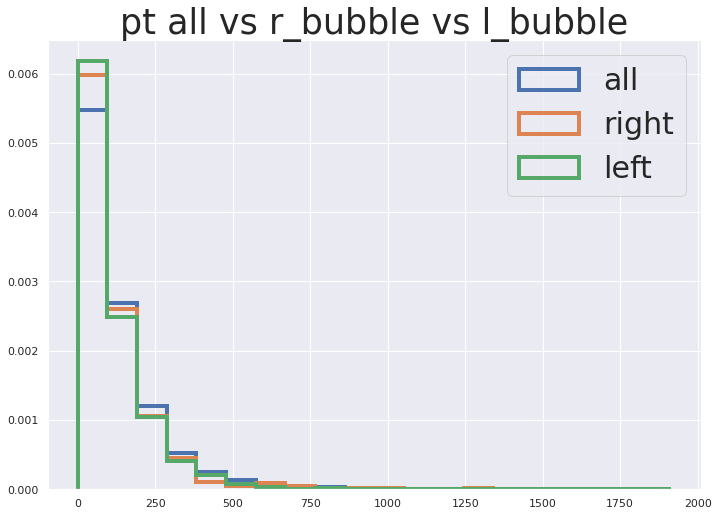

28258
854
1438


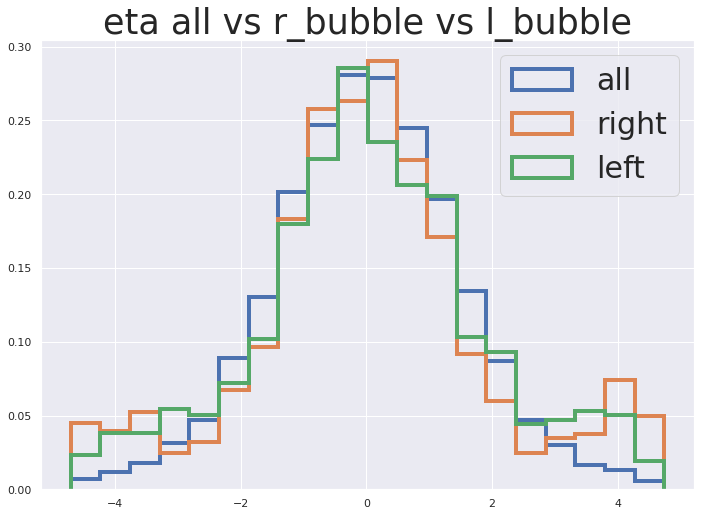

28258
854
1438


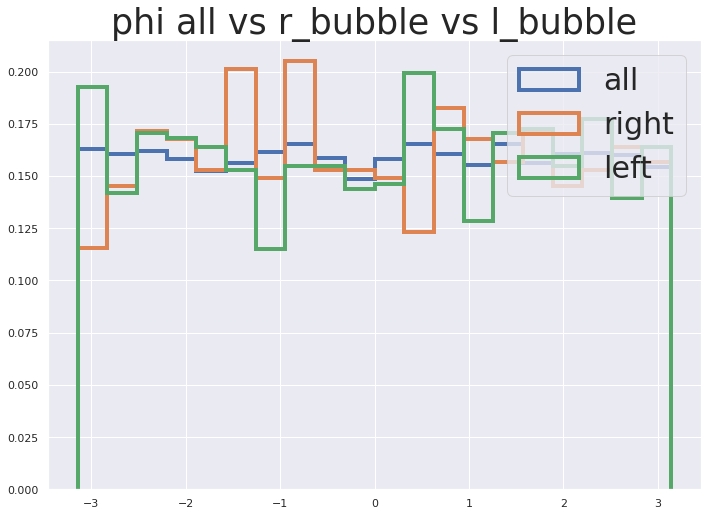

28258
24724
3534


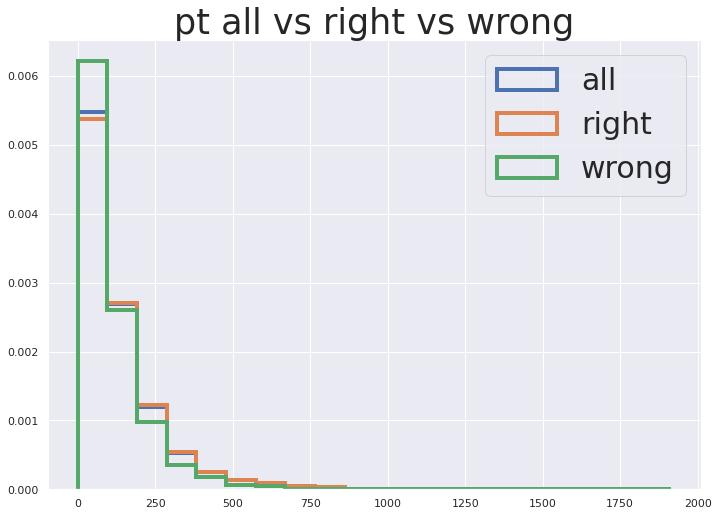

28258
24724
3534


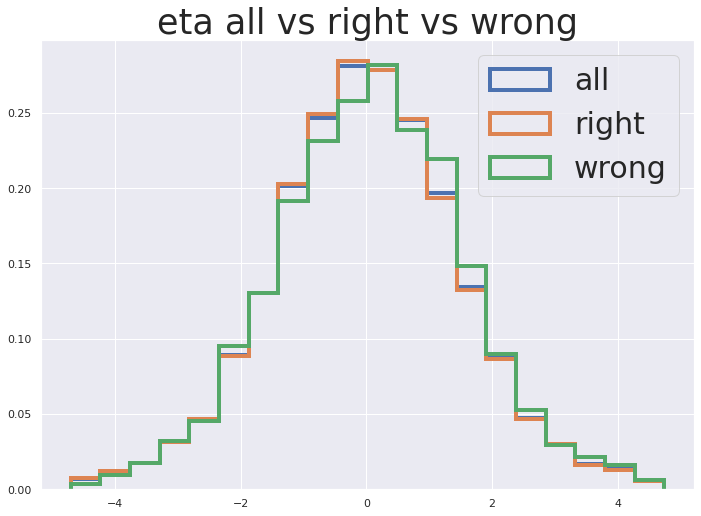

28258
24724
3534


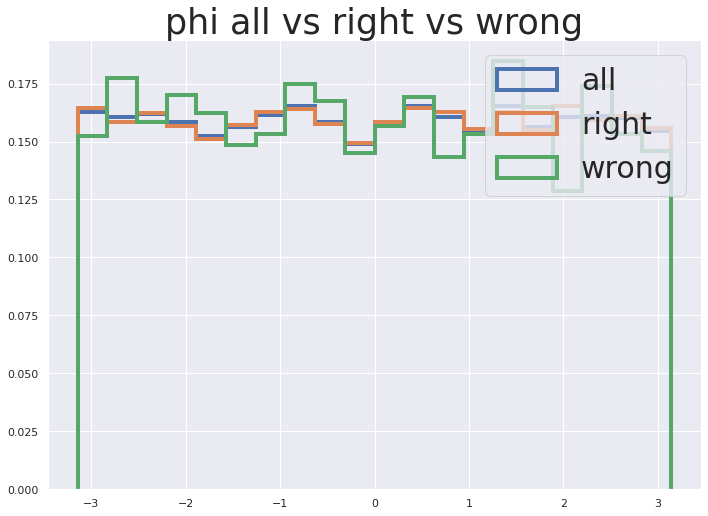

In [17]:
def plot(a, labels=None, title=None, bins=20, savename=None):
    """plot step histogram for list of arrays"""
    show_labels = not (labels is None)
    if not show_labels:
        labels = ["" for _ in a]
    
    m = min([np.min(ai) for ai in a])
    M = max([np.max(ai) for ai in a])
    kwargs = {
        "density": True,
        "histtype": 'step',
        "lw": 4,
        "range": (m, M),
        "bins": bins
    }
    for i in range(len(a)):
        flat = a[i].flatten()
        nonzero = flat[flat != 0]
        print(len(nonzero))
        plt.hist(nonzero, **kwargs, label=labels[i])
    if title:
        plt.title(title, fontsize=35)
    if show_labels:
        plt.legend(loc='best', fontsize=30)
    if savename:
        plt.savefig(savename+".png", dpi=300)
    plt.show()

plot([pt_all, r_pt, l_pt], labels=["all", "right", "left"], title="pt all vs r_bubble vs l_bubble", savename="pt_alljets")
plot([eta_all, r_eta, l_eta], labels=["all", "right", "left"], title="eta all vs r_bubble vs l_bubble", savename="eta_alljets")
plot([phi_all, r_phi, l_phi], labels=["all", "right", "left"], title="phi all vs r_bubble vs l_bubble", savename="phi_alljets")

plot([pt_all, right_pt, wrong_pt], labels=["all", "right", "wrong"], title="pt all vs right vs wrong", savename="pt_alljets_rightvswrong")
plot([eta_all, right_eta, wrong_eta], labels=["all", "right", "wrong"], title="eta all vs right vs wrong", savename="eta_alljets_rightvswrong")
plot([phi_all, right_phi, wrong_phi], labels=["all", "right", "wrong"], title="phi all vs right vs wrong", savename="phi_alljets_rightvswrong")




5000
125
193


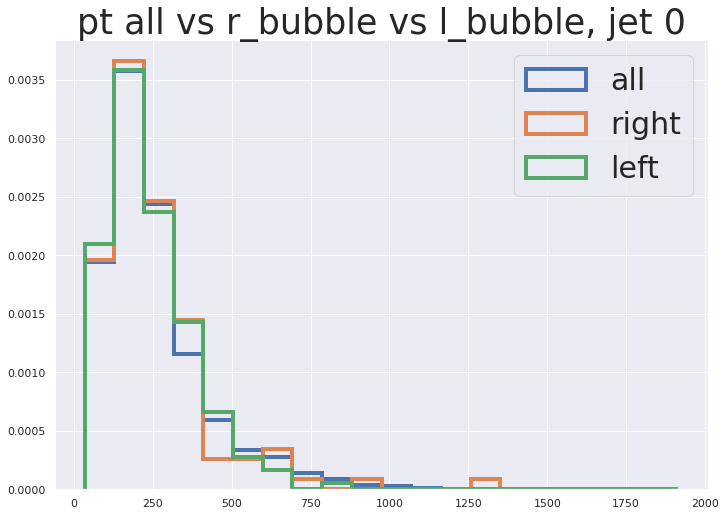

5000
125
193


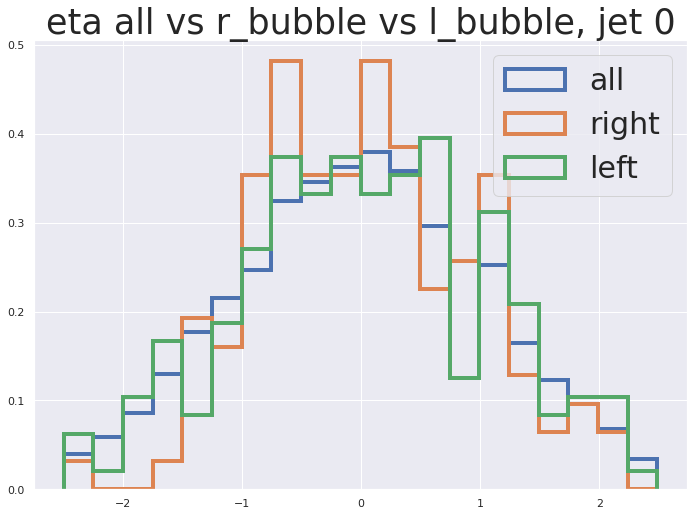

5000
125
193


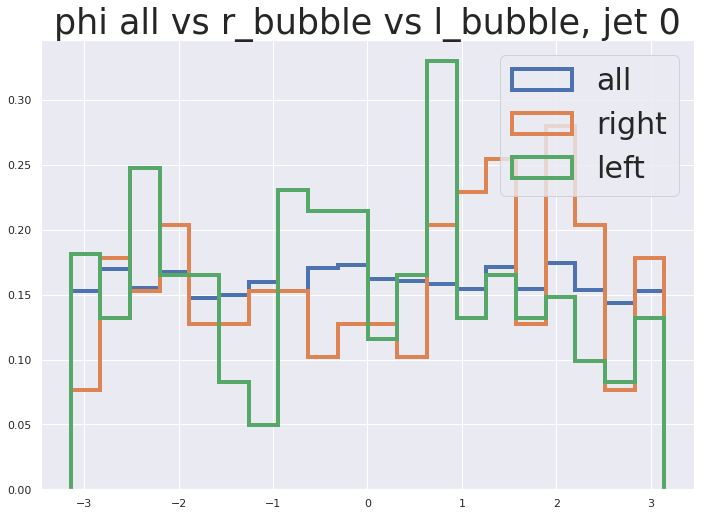

5000
125
193


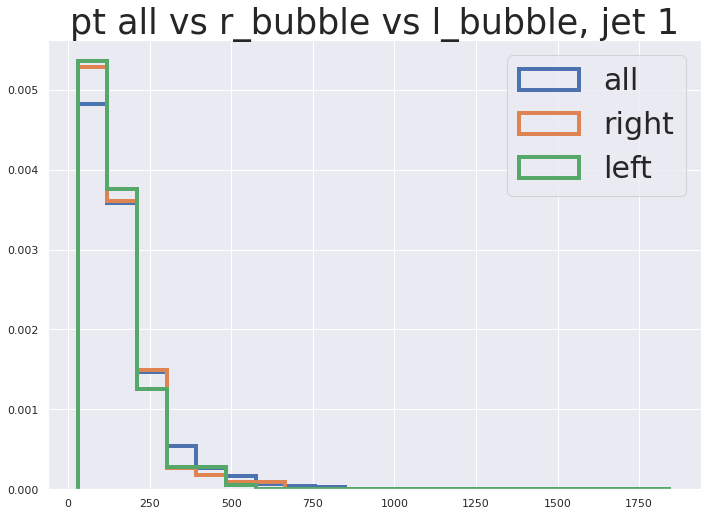

5000
125
193


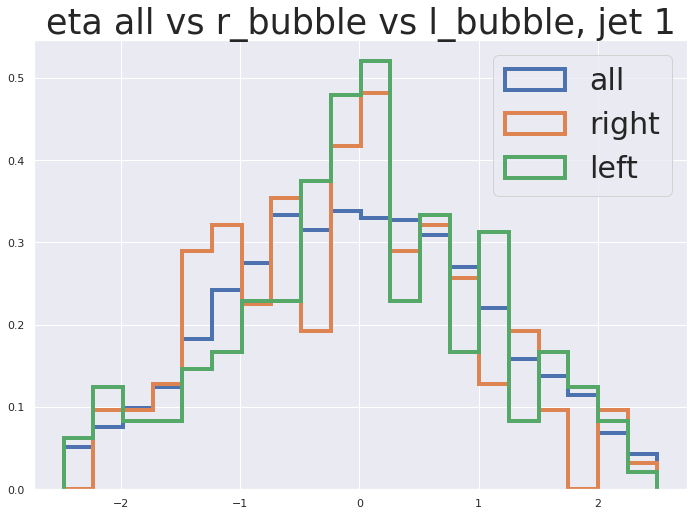

5000
125
193


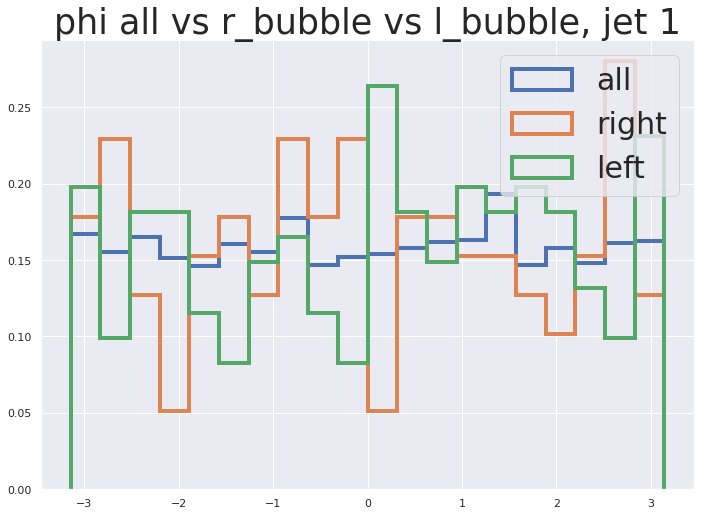

5000
125
193


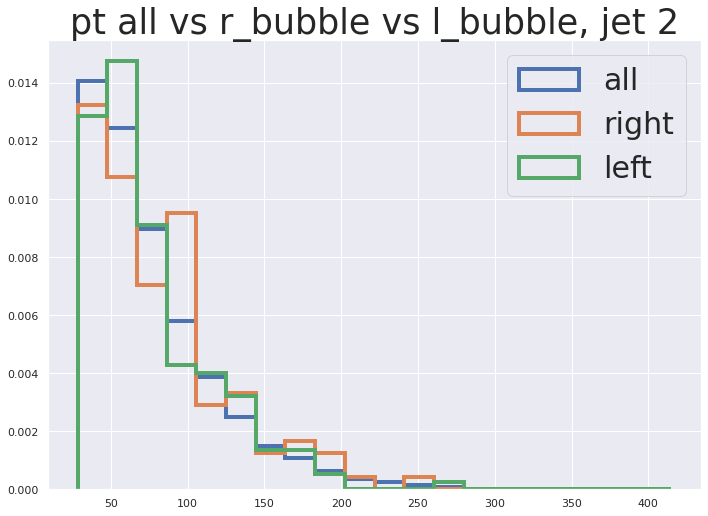

5000
125
193


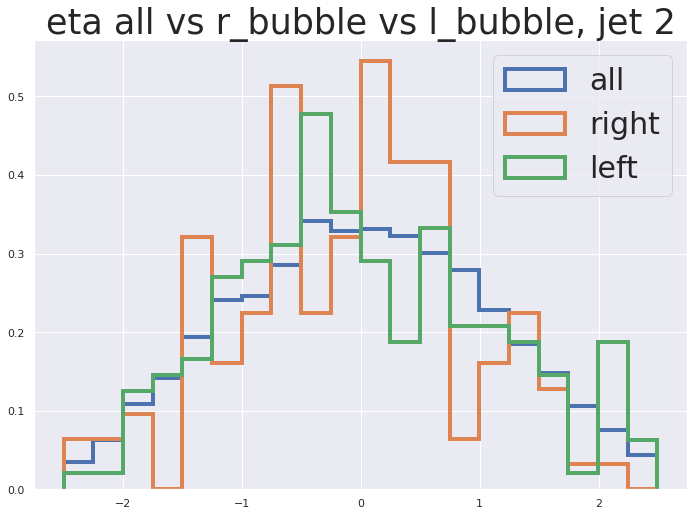

5000
125
193


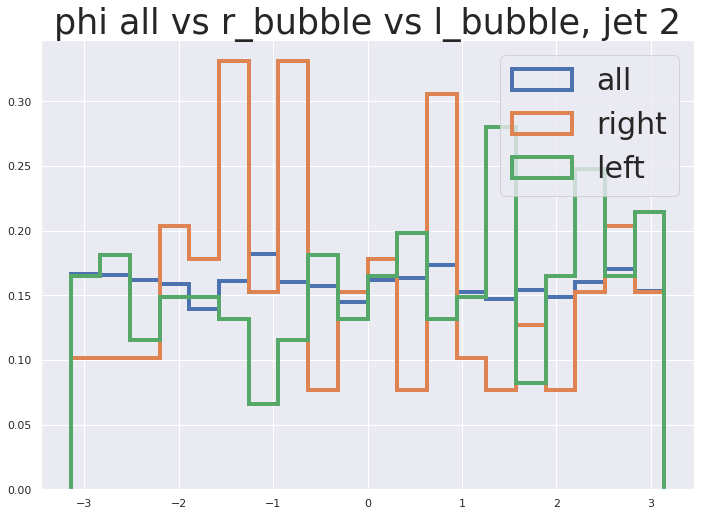

4981
125
193


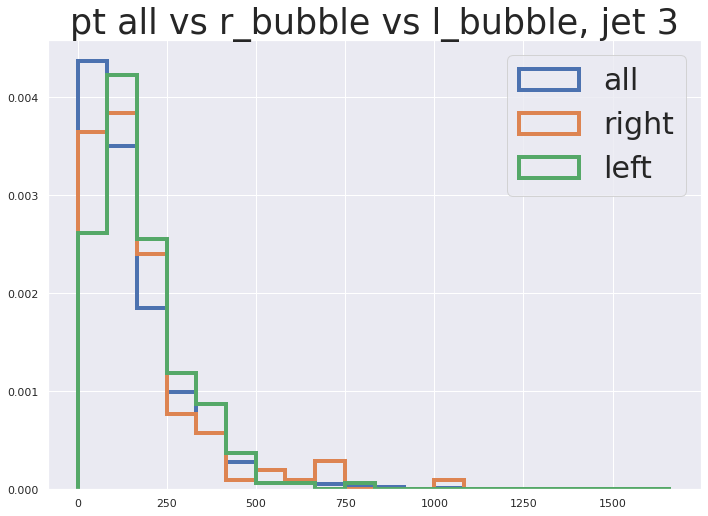

4981
125
193


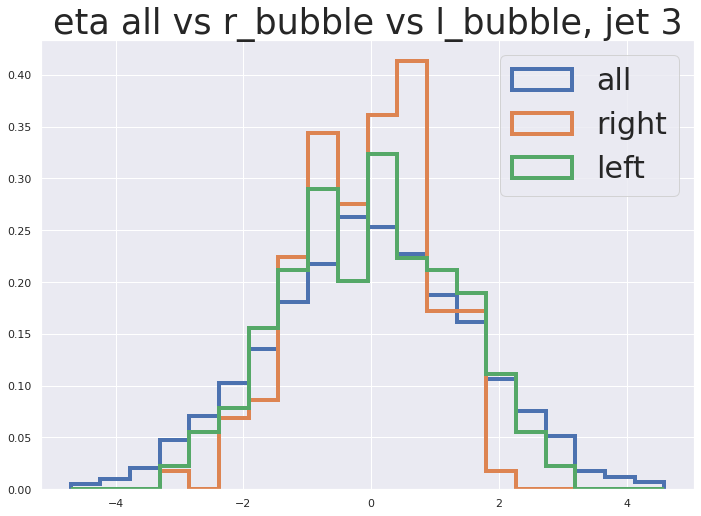

4981
125
193


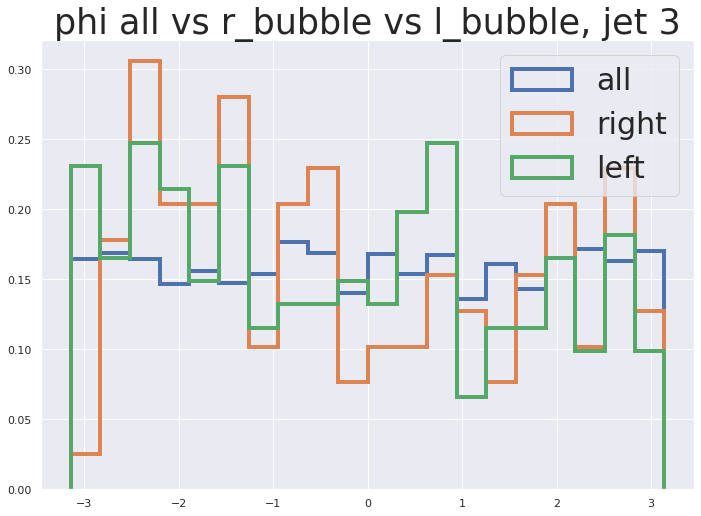

3856
125
193


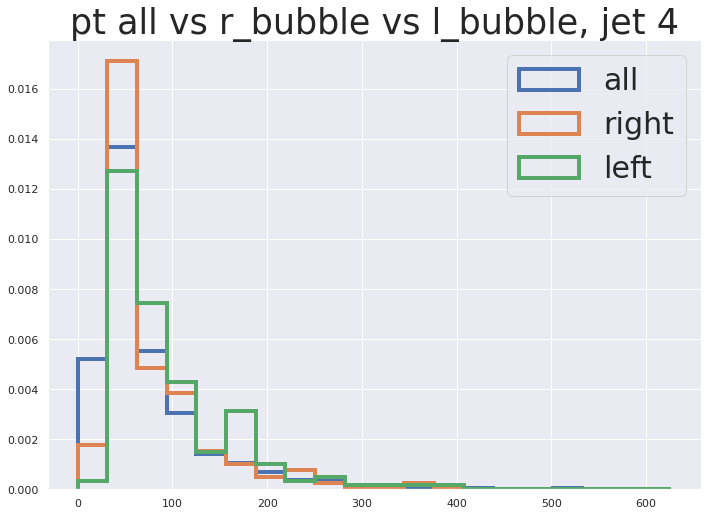

3856
125
193


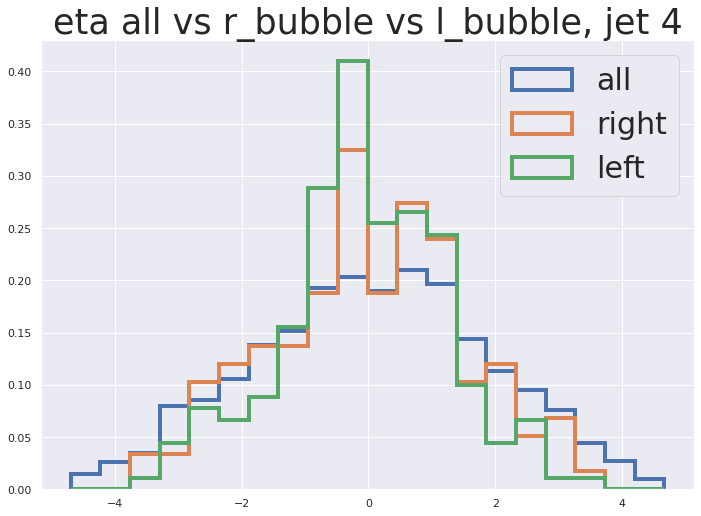

3856
125
193


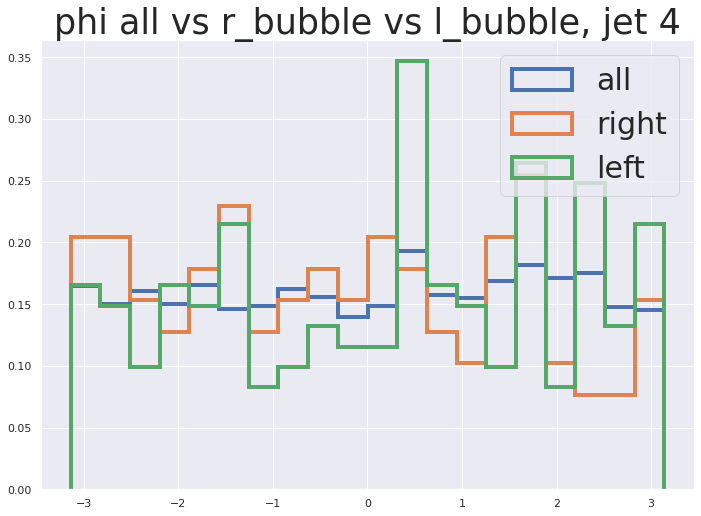

2460
125
193


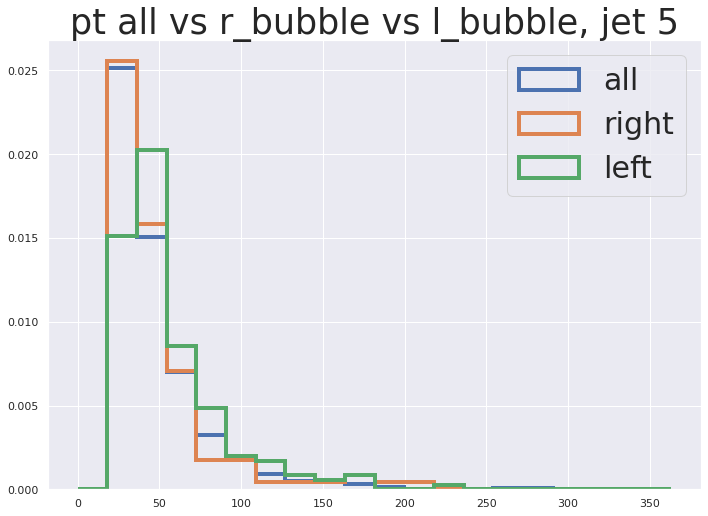

2460
125
193


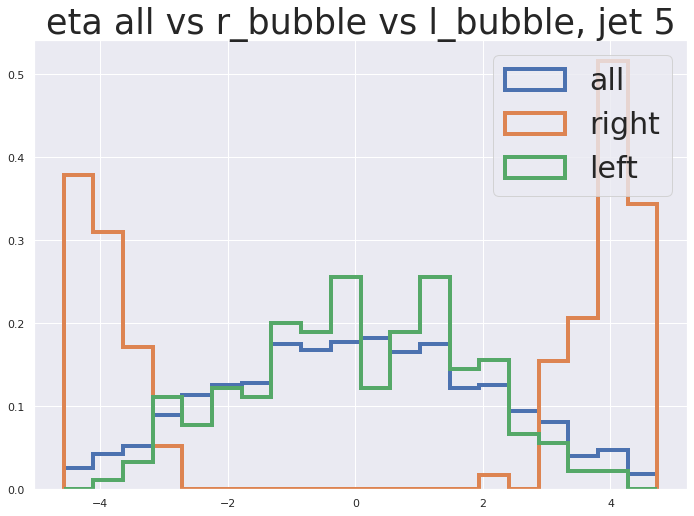

2460
125
193


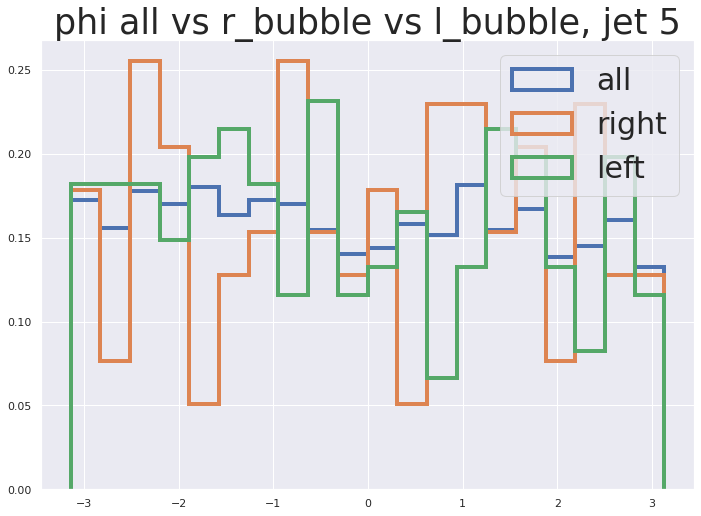

1271
68
193


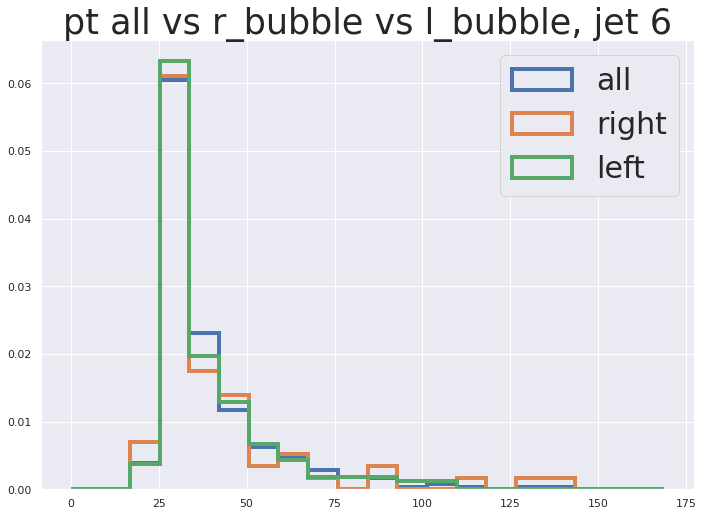

1271
68
193


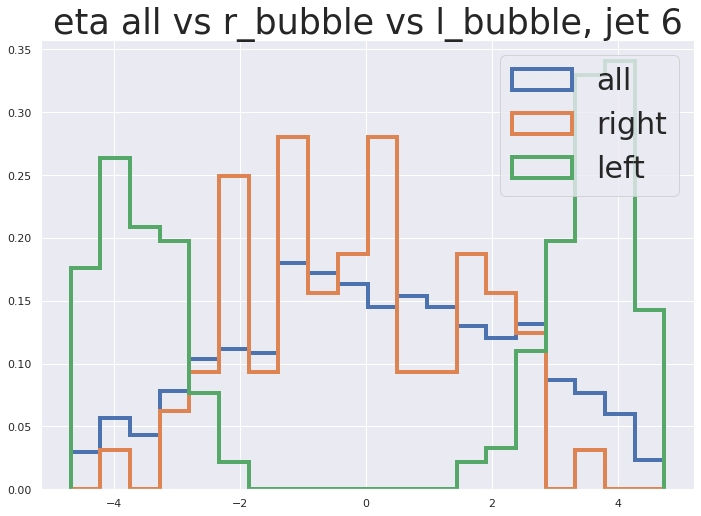

1271
68
193


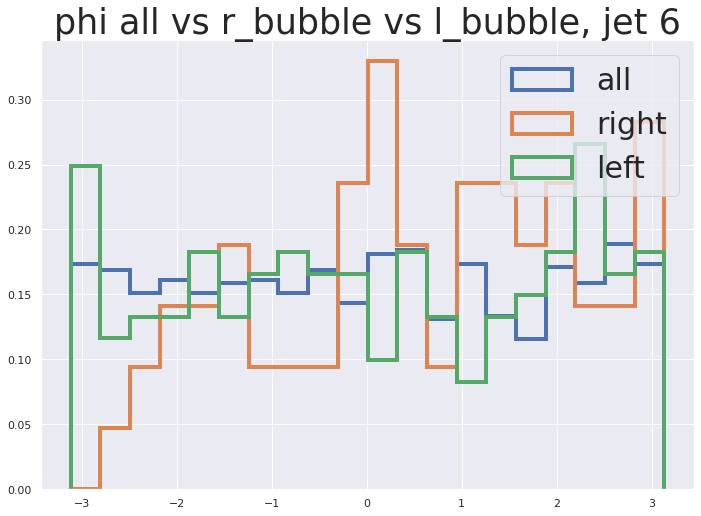

483
23
60


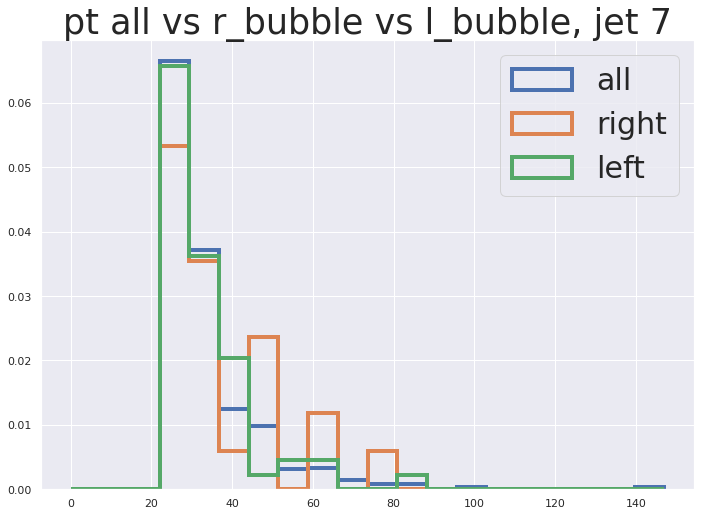

483
23
60


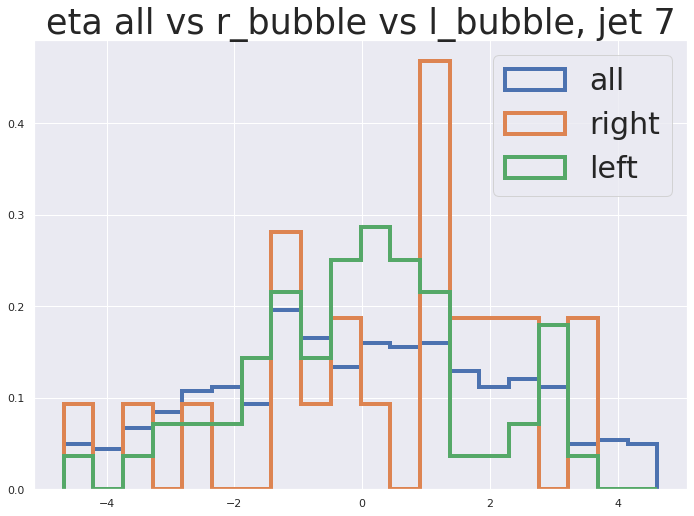

483
23
60


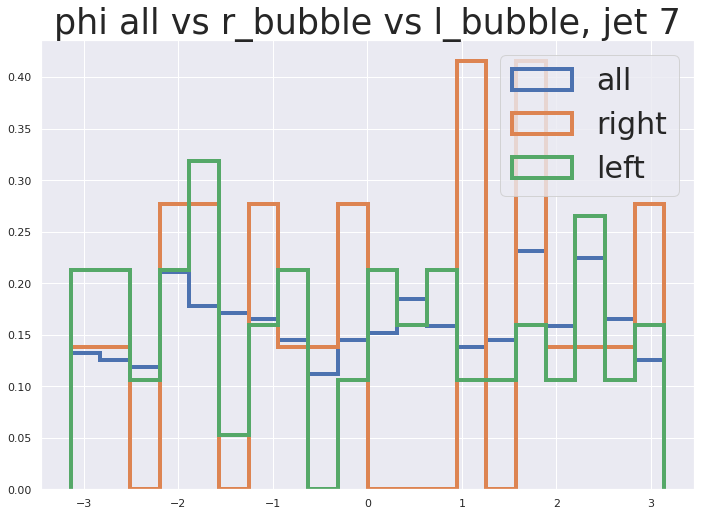

163
10
21


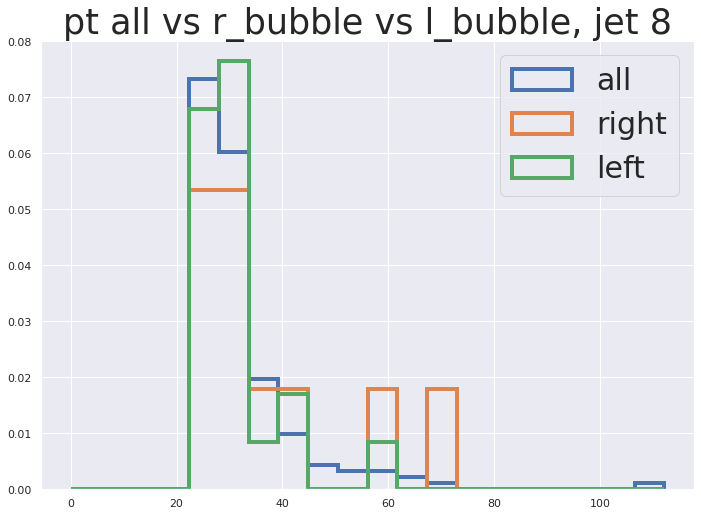

163
10
21


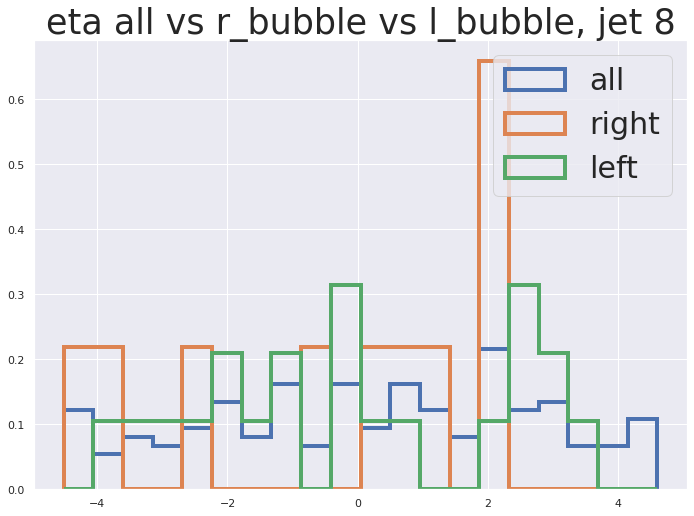

163
10
21


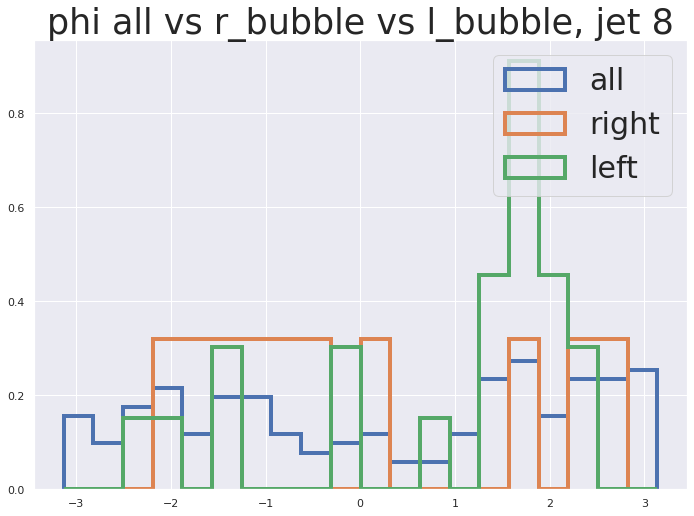

44
3
6


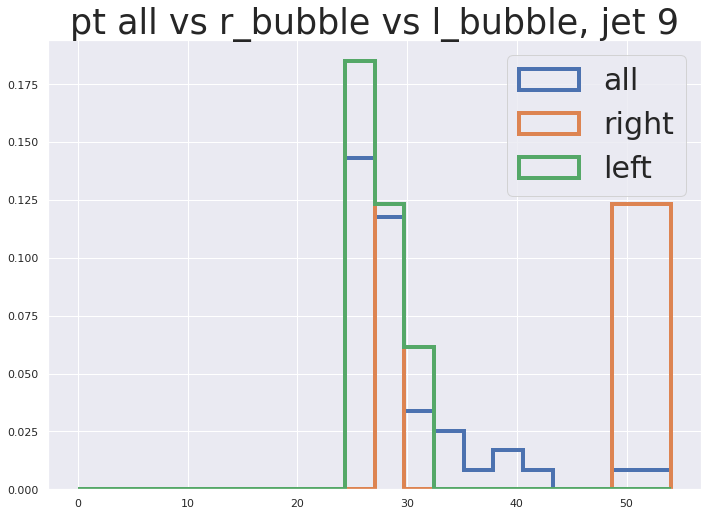

44
3
6


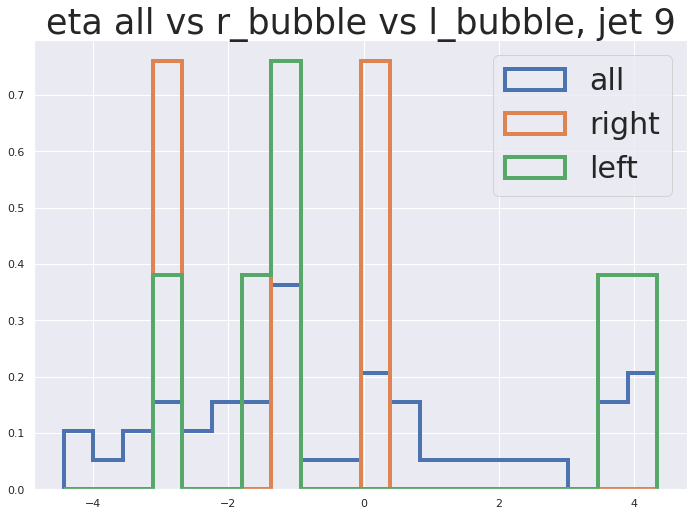

44
3
6


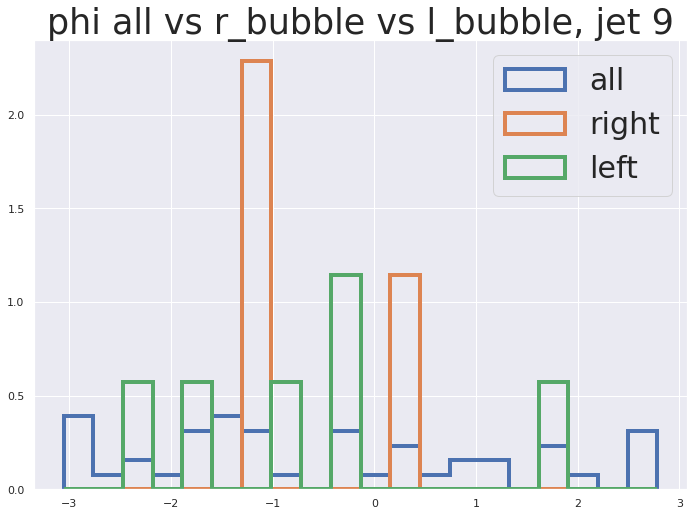

In [18]:
# pt = in bubble, pt_all = not necessarily
for i in range(10):    
    pt_all_i = pt_all[:,i]
    eta_all_i = eta_all[:,i]
    phi_all_i = phi_all[:,i]
    E_all_i = E_all[:,i]
    
    r_pt_i = r_pt[:,i]
    r_eta_i = r_eta[:,i]
    r_phi_i = r_phi[:,i]
    r_E_i = r_E[:,i]

    l_pt_i = l_pt[:,i]
    l_eta_i = l_eta[:,i]
    l_phi_i = l_phi[:,i]
    l_E_i = l_E[:,i]

    plot([pt_all_i, r_pt_i, l_pt_i], labels=["all", "right", "left"], title=f"pt all vs r_bubble vs l_bubble, jet {i}", savename=f"pt_jet_{i}")
    plot([eta_all_i, r_eta_i, l_eta_i], labels=["all", "right", "left"], title=f"eta all vs r_bubble vs l_bubble, jet {i}", savename=f"eta_jet_{i}")
    plot([phi_all_i, r_phi_i, l_phi_i], labels=["all", "right", "left"], title=f"phi all vs r_bubble vs l_bubble, jet {i}", savename=f"phi_jet_{i}")